In [2]:
########################################################
############# MSc Artificial Intelligence ##############
#### INM706-Deep Learning for Sequence Analysis ########
#### AUTHORS: Vittoria Castelnuovo, Tommaso Capecchi ####
########################################################

import re
import os
from collections import OrderedDict
from dataset import CornellCorpus
import torch
from torch.utils.data import DataLoader
from model import Encoder, Decoder, ChatbotModel, EncoderAttention, DecoderAttention, Attention, GreedySearch
from torch import optim
import torch.nn as nn
import numpy as np
import time
from nltk.translate import bleu_score
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
# check cuda availability
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

print(device)

# define the dir where to save the trained model
save_model_dir = 'saved_models'
if not os.path.exists(save_model_dir):
    os.mkdir(save_model_dir)

cpu


In [4]:
# define some useful functions

def get_movie_lines(path):
    """
    This function extracts the movie lines id and the text associated
    and store them in a dictionary.
    :param path: the path where to find the file 'movie_lines.txt'
    :return line_to_phrase: the dictionary that maps each line id to the corresponding text
    """
    file = open(path, 'r', encoding='iso-8859-1')
    dialog_data = []
    line_to_phrase = {}
    for line in file.readlines():
        dialog_data.append(line.strip().split(sep=' +++$+++ '))
    for information in dialog_data:
        line_to_phrase[information[0]] = information[-1].replace('\n', '')
    return line_to_phrase


def extract_dialogs():
    """
    This function extracts dialogs from each movie. A dialog is represented by
    a list on lineid which identifies a unique conversation in the dataset.
    :return conversation:
    """
    PATH_CONVERSATION = os.path.join(os.curdir, 'cornell-movie-dialogs-corpus/movie_conversations.txt')
    file = open(PATH_CONVERSATION, 'r', encoding='iso-8859-1')
    dialog_list = []

    # extract conversations info from 'movie_conversation.txt'
    for line in file.readlines():
        line = line.split(' +++$+++ ')
        regex = re.compile('[^a-zA-Z0-9.,!?]')
        line = regex.sub('', line[-1])
        line = line.split(',')
        dialog_list.append(line)

    return dialog_list


def create_pair_dialogs(dialogs):
    """
    This function creates each conversation pair [[Question],[Answer]]
    :param dialogs: the set of dialogs to process
    :return: the list of pairs Q&A
    """
    # dictionary that stores the following [question] -> [answer] for each line in a dialog
    dialogs_pairs = []
    for dialog in dialogs:
        for idx in range(len(dialog) - 1):
            question_to_answer = []
            question_to_answer.append(dialog[idx])
            question_to_answer.append(dialog[idx+1])
            # check if either the answer or the question is empty and if that's the case don't append it.
            if dialog[idx] and dialog[idx+1]:
                dialogs_pairs.append(question_to_answer)
    return dialogs_pairs


def format_time(start, end):
    """
    Computes the interval time between a start and an end point.
    :param start: starting time
    :param end: ending time
    :return:
    """
    elapsed_time = end - start
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_secs, elapsed_mins

def pad_sequence(sequence, max_length):
    """
    This function pads each sentence after the EOS by inserting 0s
    till the max length limit is reached.
    :param sequence: list of integers that represents a sentence
    :param max_length: maximum length of the sentence.
    :return: the padded sentence.
    """
    pad_token_idx = vocabulary.word_to_idx['<PAD>']
    while len(sequence) <= max_length:
        sequence.append(pad_token_idx)
    return sequence


def format_user_input(sequence, max_length=10):
    """
    Normalises a sentence inserted by the user to let the chatbot
    process the sequence of words.
    :param sequence: the input sentence typed by the used
    :param max_length: length limit of each sentence
    :return: the sequence of indices that represent the user's input sentence
    """
    # convert each word into index from the vocabulary
    regex = re.compile('[^a-zA-Z0-9.!?]')
    sequence = regex.sub(' ', sequence)
    # remove extra space
    sequence = re.sub(r"([.!?'])", r" \1", sequence)
    # remove non-letter characters but keep regular punctuation
    sentence = re.sub(r"[^a-zA-Z]+", r" ", sequence)
    sequence = sequence.lower()
    sequence = sequence.strip().split()
    user_seq_indices = []
    for word in sequence:
        if word in vocabulary.word_to_idx.keys():
            user_seq_indices.append(vocabulary.word_to_idx[word])
        else:
            user_seq_indices.append(vocabulary.word_to_idx['<UNK>'])

    # pad or trim the sentence
    if len(user_seq_indices) > max_length:  # trim
        user_seq_indices = user_seq_indices[:max_length]
        user_seq_indices.append(vocabulary.word_to_idx['</S>'])
    elif len(user_seq_indices) <= max_length:  # pad
        user_seq_indices.append(vocabulary.word_to_idx['</S>'])
        user_seq_indices = pad_sequence(user_seq_indices, max_length)
    user_seq_indices = torch.tensor(user_seq_indices).unsqueeze(1)
    user_seq_indices = user_seq_indices.to(device)
    return user_seq_indices


def convert_to_string(reply):
    """
    Convert a sentence of indices to the respective sequence of words.
    :param reply: the list of indices that represents a sentence created by the model
    :return: a string representation of the sentence of indices
    """
    parsed_reply = []
    for word_idx in reply:
        # if the word is PAD or END of Sentence token, ignore it.
        reply = vocabulary.vocab[word_idx]
        if word_idx == vocabulary.word_to_idx['<PAD>'] or word_idx == vocabulary.word_to_idx['</S>']:
            break
        else:
            parsed_reply.append(reply)

    return ' '.join(parsed_reply)


def map_to_idx(sequence):
    """
    Processes a sentence by mapping each word to the respective index in the vocabulary
    :param sequence: the sentence to be processed
    :return:
    """
    seq_idx = []
    for word in sequence:
        seq_idx.append(vocabulary.word_to_idx[word])
    return seq_idx


def evaluate(seq, searcher):
    """
    Process the user's input by getting the best guess after
    the sentenced has been given in input to the model.
    :param seq: the list of indices that represent the input sentence
    :param searcher: the evaluator that process the user's input
    :return: the phrase generated by the model.
    """
    # tensor should have shape [seq, 1]
    seq = seq.to(device)
    # feedforward to the searcher to get the list of most likely indices of words
    bot_reply = searcher(seq)
    # discard first element which is the start token
    bot_reply = bot_reply[1:].to(device)
    bot_reply = bot_reply.topk(1).indices.reshape(1, -1).tolist()[0]
    # convert indices to words.
    bot_reply = convert_to_string(bot_reply)
    return bot_reply


def init_model(with_attention=False, teaching_force_ratio=0.5):
    """
    Instantiates the model by creating the Encoder, the Decoder and the
    model itself which represents the seq2seq architecture.
    :param with_attention: if true then the model apply the attention mechanism
    :param teaching_force_ratio: used to alternate between generated word or gt-word during training.
    :return encoder, decoder, model: the encoder, the decoder and the seq2seq model.
    """
    if with_attention:
        # init with attention
        encoder = EncoderAttention(embedding_size, hidden_size, vocabulary.__len__()).to(device)
        attention = Attention(hidden_size).to(device)
        decoder = DecoderAttention(embedding_size, hidden_size, vocabulary.__len__(), attention=attention).to(
            device)
        model = ChatbotModel(encoder, decoder, vocabulary.__len__(), with_attention=True, tf_ratio=teaching_force_ratio).to(device)
        return encoder, decoder, model
    else:
        # init with no attention
        encoder = Encoder(embedding_size, hidden_size, vocabulary.__len__()).to(device)
        decoder = Decoder(embedding_size, hidden_size, vocabulary.__len__()).to(device)
        model = ChatbotModel(encoder, decoder, vocabulary.__len__(), with_attention=False,tf_ratio=teaching_force_ratio).to(device)
        return encoder, decoder, model


def run_bot(searcher, testing=True, max_length=10):
    """
    Executes the model. The user is prompted with the sentence to
    insert and then the sentence is processed by the model which
    will output the corresponding reply.
    :param searcher: the evaluator used to search for the best reply
    :param testing: if true, a pre-setted phrase will be evaluated
    :param max_length: limit length for each sentence to be processed
    :return:
    """
    model.encoder.eval()
    model.decoder.eval()
    if testing:
        user_input = 'Hey how are you?'
        user_input_idx = format_user_input(user_input, max_length)
        reply = evaluate(user_input_idx, searcher)
        print(reply)
    else:
        while(True):
            try:
                # ask the user for the input
                user_input = input('> ')
                # format the user input.
                if user_input == 'quit':
                    break
                user_input_idx = format_user_input(user_input, max_length)
                # run the evaluate function to get bot's reply
                reply = evaluate(user_input_idx, searcher)
                print(reply)
            except KeyError:
                print('Error: While parsing the input sentence...')

In [5]:
# Define the Vocabulary class

class Vocabulary:
    """
    This class implements the vocabulary used to store
    all the words extracted from the Dataset
    """
    def __init__(self, idx_to_text, dialogs_ids):
        self.dialogs_ids = dialogs_ids
        self.idx_to_text = self.normalize_sentence(idx_to_text)
        # maps each word to a unique integer
        self.word_to_idx = self.map_word_to_idx()
        # maps each unique index to the corresponding word
        self.vocab = self.map_idx_to_word()

    def __len__(self):
        return len(self.vocab)

    def normalize_sentence(self, idx_to_text):
        """
        Process each movie line so that each movie
        dialog contains only characters. Empty sentences
        are filtered
        :param idx_to_text: maps each movie line to the corresponding sentece
        :return: normalized dictionary that maps each movie ID to its sentence
        """
        normalized_idx_to_sentence = {}
        for line_id, sentence in zip(idx_to_text.keys(), idx_to_text.values()):
            # convert each word in the sentence to a lower case
            sentence = sentence.lower()
            # eliminate extra spaces for punctuation
            sentence = re.sub(r"([.,!?'])", r" \1", sentence)
            # remove non-letter characters but keep regular punctuation
            sentence = re.sub(r"[^a-zA-Z]+", r" ", sentence)
            normalized_idx_to_sentence[line_id] = sentence

        # filters empty q-a pairs
        filtered_sentences = {}
        for line_id, text in zip(normalized_idx_to_sentence.keys(), normalized_idx_to_sentence.values()):
            if text != ' ':
                filtered_sentences[line_id] = text
        print('Filtered sentences: {}'.format(len(normalized_idx_to_sentence) - len(filtered_sentences)))
        return normalized_idx_to_sentence

    def map_idx_to_word(self):
        """
        Assign to each word a unique numeric value, so that
        an integer is mapped to a unique word
        :return: an ordered dictionary with the corresponding mapping
        """
        words = self.word_to_idx.keys()
        index = self.word_to_idx.values()
        idx_to_word = OrderedDict()
        for w, i in zip(words, index):
            idx_to_word[i] = w
        return idx_to_word

    def map_word_to_idx(self):
        """
        Maps each word to a unique index to create a vocabulary.
        The SOS, EOS, UNK, PAD tokens are also inserted into the data structure.
        :return:
        """
        word_to_idx = {}
        count_words = 0
        for dialogs in self.dialogs_ids:
            for line in dialogs:
                sentence = self.idx_to_text[line]
                for word in sentence.strip().split():
                    if word not in word_to_idx:
                        word_to_idx[word] = count_words
                        count_words += 1
        start_token = '<S>'
        end_token = '</S>'
        unknown_token = '<UNK>'
        pad_token = '<PAD>'
        word_to_idx = sorted(word_to_idx)
        word_to_idx.insert(0, unknown_token)
        word_to_idx.insert(0, end_token)
        word_to_idx.insert(0, start_token)
        word_to_idx.insert(0, pad_token)
        word_to_idx = self.build_dictionary(word_to_idx)
        return word_to_idx

    def build_dictionary(self, word_collection):
        """
        Create the ordered dictionary from the mapping dictionary {word:id}.
        :param word_collection: a dictionary that stores the association between word:id
        :return: the dictionary represented as OrderedDict
        """
        word_to_idx = OrderedDict()
        for idx, word in enumerate(word_collection):
            word_to_idx[word] = idx
        return word_to_idx

In [6]:
dirs = os.path.join(os.curdir, 'cornell-movie-dialogs-corpus/movie_lines.txt')
idx_to_text = get_movie_lines(dirs)
# create a list of dialogs for each movie.
dialogs = extract_dialogs()
# for each movie, create pairs dialogs (Q/A). This is the actual data used for training.
pair_dialogs_idx = create_pair_dialogs(dialogs)
# instantiate the vocabulary
vocabulary = Vocabulary(idx_to_text, dialogs)
print('Total words counted in the vocabulary: {}'.format(vocabulary.__len__()))

# shuffle data
np.random.shuffle(pair_dialogs_idx)
train_data = CornellCorpus(pair_dialogs_idx, vocabulary, max_length=10, stage='train')
val_data = CornellCorpus(pair_dialogs_idx, vocabulary, max_length=10, stage='val')
test_data = CornellCorpus(pair_dialogs_idx, vocabulary, max_length=10, stage='test')

print('Total training batches: {}, Total val batches: {}, Total test batches: {}'.format(train_data.__len__(),
                                                                                         val_data.__len__(),
                                                                                         test_data.__len__()))

# hyperparameters
batch_size = 64
hidden_size = 256
embedding_size = 500


# init dataloader
load_args = {'batch_size': batch_size, 'shuffle': True}
train_dataloader = DataLoader(train_data, **load_args)
val_dataloader = DataLoader(val_data, **load_args)
load_args_test = {'batch_size': 1, 'shuffle': True}
test_dataloader = DataLoader(test_data, **load_args_test)

# init model
encoder, decoder, model = init_model(with_attention=True)

# init loss function
criterion = nn.CrossEntropyLoss(ignore_index=vocabulary.word_to_idx['</S>'])
epoch_history = []

# init evaluator --> if attention=True, then also the model requires with_attention=True
searcher = GreedySearch(encoder, decoder, vocabulary, attention=True).to(device)

Filtered sentences: 64
Total words counted in the vocabulary: 48091
Total training batches: 177226, Total val batches: 22151, Total test batches: 22149


In [7]:
# visualize sample of processed sentences.
dataiter = iter(train_dataloader)
sample_data = []
for idx in range(5):
    batch_idx, data = dataiter.__next__()
    print("#### Sample Datapoint - {} ####".format(idx+1))
    print("Question: {}".format(data[0].tolist()))
    print("Answer: {}".format(data[1].tolist()))
    print()

#### Sample Datapoint - 1 ####
Question: [1, 20447, 12056, 2, 0, 0, 0, 0, 0, 0, 0, 0]
Answer: [1, 22449, 47811, 46371, 47825, 2179, 2, 0, 0, 0, 0, 0]

#### Sample Datapoint - 2 ####
Question: [1, 21883, 42754, 47825, 28436, 12529, 41281, 2, 0, 0, 0, 0]
Answer: [1, 46597, 42634, 42592, 36386, 17956, 1394, 42592, 36386, 4, 17956, 2]

#### Sample Datapoint - 3 ####
Question: [1, 28488, 47811, 11319, 4, 29004, 2, 0, 0, 0, 0, 0]
Answer: [1, 27047, 19622, 25003, 28870, 14172, 11552, 2, 0, 0, 0, 0]

#### Sample Datapoint - 4 ####
Question: [1, 46718, 42604, 19204, 21883, 42592, 35331, 19566, 14612, 21933, 36386, 2]
Answer: [1, 47811, 26958, 42604, 17630, 29422, 10372, 14172, 42793, 42659, 46631, 2]

#### Sample Datapoint - 5 ####
Question: [1, 28689, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Answer: [1, 20447, 10100, 24279, 47811, 43151, 37380, 42754, 2, 0, 0, 0]



In [8]:
epochs = 70
def train_loop():
    """
    The training loop used to train the model. At each iteration a mini-batch
    of a predefined size N is loaded and processed. The shape of each mini-batch of data point
    is [batch_size, max_len]. Each batch is transposed so that by accessing the values
    by the first dimension we can process all the indices at time step t of the entire batch.
    To keep track of the intermediate results we print
    every 500 iterations the running loss.
    :return:
    """
    batch_history = []
    model.encoder.train()
    model.decoder.train()
    avg_loss = 0
    # start timer
    start_time = time.time()
    for idx, X in enumerate(train_dataloader):
        # default previous weights values
        model.encoder.optim.zero_grad()
        model.decoder.optim.zero_grad()

        # transpose both input sentence and target sentence to access
        # the the i-th word for each batch at each given time step t.
        question = torch.transpose(X[0].to(device), 0, 1)
        answer = torch.transpose(X[1].to(device), 0, 1)
        # compute the output. Recall the output size should be (seq_len, batch_size, voc_size)
        output = model(question, answer)

        # don't consider the first element in all batches because it's the '<S>' token
        output = output[1:].to(device)
        answer = answer[1:].to(device)
        # reshape output so that we can comput the loss. The CrossEntropyLoss class
        # expects the input to be [N, n_classes] for the predictions.
        output = output.reshape(-1, output.shape[2])
        answer = answer.reshape(-1)
        # compute loss
        loss = criterion(output, answer)
        # backpropagate to compute gradients
        loss.backward()
        # clip gradients to avoid exploding values
        torch.nn.utils.clip_grad_norm_(model.encoder.parameters(), max_norm=50)
        torch.nn.utils.clip_grad_norm_(model.decoder.parameters(), max_norm=50)
        # perform weights update
        model.encoder.optim.step()
        model.decoder.optim.step()
        # normalize loss by the length of the sentence
        batch_history.append(loss.item()/ question.shape[0])
        # print current loss every 500 processed batches
        if idx % 500 == 0:
            # end of epoch
            end_time = time.time()
            # format elapsed time
            elapsed_secs, elapsed_mins = format_time(start_time, end_time)
            print('BATCH [{}/{}], LOSS TRAINING: {}, eta: {}m {}s'.format(idx,
                                                                          train_dataloader.__len__(),
                                                                          loss,
                                                                          elapsed_mins,
                                                                          elapsed_secs))
            # start timer
            start_time = time.time()
    avg_loss = np.mean(batch_history)
    return avg_loss

def val_loop():
    """
    The validation loop used to keep track of the model performance during training. At each iteration a mini-batch
    of a predefined size N is loaded and processed. The shape of each mini-batch of data point
    is [batch_size, max_len]. Each batch is transposed so that by accessing the values
    by the first dimension we can process all the indices at time step t of the entire batch.
    To keep track of the intermediate results we print
    every 500 iterations the running loss.
    :return:
    """
    model.encoder.eval()
    model.decoder.eval()
    batch_history = []
    avg_loss = 0
    for idx, X in enumerate(val_dataloader):
        # transpose both input sentence and target sentence to access using the first dimension
        # the the i-th word for each batch at each given time step t.
        question = torch.transpose(X[0].to(device), 0, 1)
        answer = torch.transpose(X[1].to(device), 0, 1)
        # compute the output. Recall the output size should be (seq_len, batch_size, voc_size)
        output = model(question, answer)
        # don't consider the first element in all batches because it's the '<S>' token
        output = output[1:].to(device)
        answer = answer[1:].to(device)
        # reshape both question and answer to the correct size for the loss function
        output = output.reshape(-1, output.shape[2])
        answer = answer.reshape(-1)
        # compute the loss
        loss = criterion(output, answer)

        # keep track of the loss
        batch_history.append(loss.item()/ question.shape[0])
    avg_loss = np.mean(batch_history)
    return avg_loss

In [9]:
### TRAIN LOOP ###

epoch_idx = 0
train_history = []
val_history = []
if model.attention:
    checkpoint_path = os.path.join(os.curdir, 'saved_models/checkpoint.pth')
    path_saved_model = os.path.join(os.curdir, 'saved_models/trained_model.pth')
else:
    checkpoint_path = os.path.join(os.curdir, 'saved_models/checkpoint_no_att.pth')
    path_saved_model = os.path.join(os.curdir, 'saved_models/trained_model_no_att.pth')
    # check if the model is already trained
if os.path.exists(path_saved_model):
    # load state_dict
    print('Trained model found. Loading...')
    model.load_state_dict(torch.load(path_saved_model, map_location=torch.device(device)))
    print('Model loaded.')
else:
    # check if a training phase was already started
    if os.path.exists(checkpoint_path):
        # load trained values
        loaded_checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
        print('Checkpoint found. Restore from [{}/{}] epoch.'.format(loaded_checkpoint['epoch'], epochs))
        # restore previous values
        epoch_idx = loaded_checkpoint['epoch']
        model.load_state_dict(loaded_checkpoint['model_sd'])
        model.encoder.optim.load_state_dict(loaded_checkpoint['optim_sd_encoder'])
        model.decoder.optim.load_state_dict(loaded_checkpoint['optim_sd_decoder'])
        train_history = loaded_checkpoint['train_history']
        val_history = loaded_checkpoint['val_history']

    # UNCOMMENT THE BELOW TO CONTINUE TRAINING

    print('Start training...')
    for epoch in range(epoch_idx, epochs):
        # start counting epoch time
        start_time = time.time()
        # compute train loss
        train_loss = train_loop()
        train_history.append(train_loss)
        # compute val loss
        val_loss = val_loop()
        val_history.append(val_loss)
        # store train and val loss for later analysis
        epoch_history.append((train_loss, val_loss))
        # end of epoch
        end_time = time.time()
        # format elapsed time
        elapsed_secs, elapsed_mins = format_time(start_time, end_time)
        checkpoint = {'epoch': epoch+1,
                      'model_sd': model.state_dict(),
                      'optim_sd_encoder': model.encoder.optim.state_dict(),
                      'optim_sd_decoder': model.decoder.optim.state_dict(),
                      'train_history': train_history,
                      'val_history': val_history
                      }
        torch.save(checkpoint, checkpoint_path)
        print("EPOCH [{}/{}] | Train Loss: {} | Val. Loss: {} | time: {}m {}s".format(epoch+1,
                                                                                           epochs,
                                                                                           train_loss,
                                                                                           val_loss,
                                                                                           elapsed_mins,
                                                                                          elapsed_secs))
        if epoch % 10 == 0:
            print("Test learning, input phrase: 'Hey how are you?'")
            if model.attention:
                searcher = GreedySearch(encoder, decoder, vocabulary, attention=True).to(device)
            else:
                searcher = GreedySearch(encoder, decoder, vocabulary, attention=False).to(device)
            run_bot(searcher, testing=True)
    # save training model.
    print('Training completed.')
    torch.save(model.state_dict(), path_saved_model)

Trained model found. Loading...
Model loaded.


In [10]:
# Evaluating the Chatbot
run_bot(searcher, testing=False)

> hello
i a years of
> how are you
i and between that s it day us
> what do you do for living
i
> i what?
i blimey are he chronic gardena with times so it
> you seem confused
i that were name people you bartered to last
> ok bye
you
> quit


In [11]:
def compute_blue(searcher):
    """
    This function computes the bleu score.
    :return: the blue score
    """
    smoothing_fn = bleu_score.SmoothingFunction()
    score = 0
    for idx, test_data in enumerate(test_dataloader):
        question = torch.transpose(test_data[0], 0, 1).to(device)
        answer = torch.transpose(test_data[1], 0, 1)
        answer = answer[1:]
        answer = answer.reshape(1, -1).tolist()[0]
        output = searcher(question)
        output = output[1:]
        prediction = output.topk(1).indices.reshape(1, -1).tolist()[0]
        prediction = convert_to_string(prediction)
        answer = convert_to_string(answer)
        answer = [answer.split()]
        prediction = prediction.split()
        score += bleu_score.sentence_bleu(answer, prediction, smoothing_function=smoothing_fn.method5, weights=(0.5, 0.5))
        if idx % 2000 == 0:
            print('Sentences processed: [{}/{}]'.format(idx+1, len(test_dataloader)))
    return (score/len(test_dataloader))*100

In [12]:
def load_model(model):
    if model.attention:
        checkpoint_path = os.path.join(os.curdir, 'saved_models/checkpoint.pth')
        path_saved_model = os.path.join(os.curdir, 'saved_models/trained_model.pth')
    else:
        checkpoint_path = os.path.join(os.curdir, 'saved_models/checkpoint_no_att.pth')
        path_saved_model = os.path.join(os.curdir, 'saved_models/trained_model_no_att.pth')
        # check if the model is already trained
    if os.path.exists(path_saved_model):
        # load state_dict
        print('Trained model found. Loading...')
        model.load_state_dict(torch.load(path_saved_model, map_location=torch.device(device)))
        print('Model loaded.')
    else:
        # check if a training phase was already started
        if os.path.exists(checkpoint_path):
            # load trained values
            loaded_checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
            print('Checkpoint found. Restore from [{}/{}] epoch.'.format(loaded_checkpoint['epoch'], epochs))
            # restore previous values
            epoch_idx = loaded_checkpoint['epoch']
            model.load_state_dict(loaded_checkpoint['model_sd'])
            model.encoder.optim.load_state_dict(loaded_checkpoint['optim_sd_encoder'])
            model.decoder.optim.load_state_dict(loaded_checkpoint['optim_sd_decoder'])

def load_values(model):
    if model.attention:
        checkpoint_path = os.path.join(os.curdir, 'saved_models/checkpoint.pth')
        path_saved_model = os.path.join(os.curdir, 'saved_models/trained_model.pth')
    else:
        checkpoint_path = os.path.join(os.curdir, 'saved_models/checkpoint_no_att.pth')
        path_saved_model = os.path.join(os.curdir, 'saved_models/trained_model_no_att.pth')
    #load stored values
    loaded_checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    # retrieve train loss history
    train_history = loaded_checkpoint['train_history']
    val_history = loaded_checkpoint['val_history']
    return train_history, val_history

In [13]:
# testing
# init model with attention
encoder_att, decoder_att, model_att = init_model(with_attention=True)
searcher_att = GreedySearch(encoder, decoder, vocabulary, attention=True).to(device)
# # init model with no attention
encoder_noatt, decoder_noatt, model_noatt = init_model(with_attention=False)
searcher_noatt = GreedySearch(encoder, decoder, vocabulary, attention=False).to(device)

# load values for both models
load_model(model_att)
load_model(model_noatt)

train_loss_att, val_loss_att = load_values(model_att)
train_loss_noatt, val_loss_noatt = load_values(model_noatt)

Trained model found. Loading...
Model loaded.
Trained model found. Loading...
Model loaded.


In [14]:
def plot_train_val_loss(train_att, val_att, train_noatt, val_noatt):
    experiments = [[train_att, val_att],[train_noatt, val_noatt]]
    plt.figure(figsize=(15, 5))
    for idx, data in enumerate(experiments):
        plt.subplot(1, 2, idx+1)
        plt.plot(data[0], label='Train Loss-{}Att'.format('' if idx == 0 else 'No'))
        plt.plot(data[1], label='Val Loss-{}Att'.format('' if idx == 0 else 'No'))
        plt.xlabel('Episodes')
        plt.ylabel('Loss')
        plt.title('Train vs Val Loss {}'.format('with Attention' if idx == 0 else 'no Attention'))
        plt.legend()
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

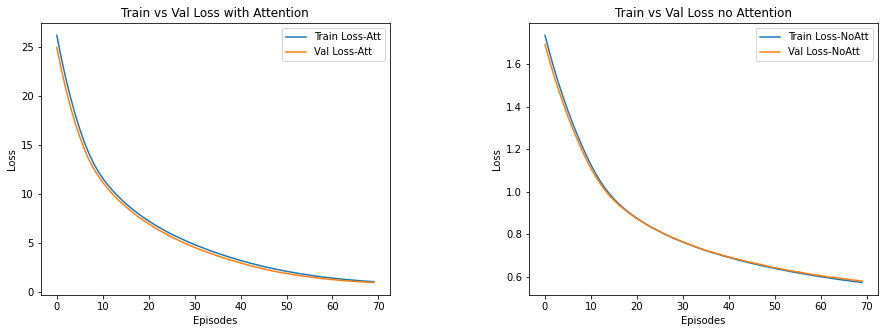

In [15]:
plot_train_val_loss(train_loss_att, val_loss_att, train_loss_noatt, val_loss_noatt)

In [16]:
# init model with attention
encoder, decoder, model = init_model(with_attention=True)
searcher = GreedySearch(encoder, decoder, vocabulary, attention=True).to(device)
# load model
load_model(model)
# compute blue score
blue_att = compute_blue(searcher)
print('Blue score model with attention: {}'.format(blue_att))

Trained model found. Loading...
Model loaded.
Sentences processed: [1/22149]


KeyboardInterrupt: 

In [17]:
# init model without attention
encoder, decoder, model = init_model(with_attention=False)
searcher = GreedySearch(encoder, decoder, vocabulary, attention=False).to(device)
#laod model
load_model(model)
blue_noatt = compute_blue(searcher)
print('Blue score model without attention: {}'.format(blue_noatt))

Trained model found. Loading...
Model loaded.
Sentences processed: [1/22149]


KeyboardInterrupt: 